In [1]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

from datasets import Dataset 
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback
import torch

from data_utils import DataUtils

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
MAX_SEQ_LEN = 256
BATCH_SIZE = 16
DS_SPLIT = 0.2
MIN_SPECIALITY_THRESHOLD = 100
DATASET_PATH = 'data/mtsamples.csv'
MODEL_NAME = 'nlpie/distil-biobert'

In [4]:
df = pd.read_csv(DATASET_PATH, usecols=['medical_specialty', 'transcription'])
df.head()

,medical_specialty,transcription
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...


In [5]:
utils = DataUtils()
df = utils.handle_nulls(df)
df = utils.handle_duplicates(df)

df['text'] = df['transcription'].map(utils.clean_text)
df['medical_specialty'] = df['medical_specialty'].str.strip()

===== Null Summary =====
medical_specialty     0
transcription        33
dtype: int64
Dropping rows with missing values...
===== Duplicate Summary =====
Count: 2
Dropping duplicate rows...


===== Class Distribution =====
medical_specialty
General Medicine / SOAP / Chart / Progress Notes    425
Cardiovascular / Pulmonary                          371
Orthopedic                                          355
Neurology / Neurosurgery                            317
Gastroenterology                                    224
Urology                                             156
Obstetrics / Gynecology                             155
Discharge Summary                                   108
Name: count, dtype: int64


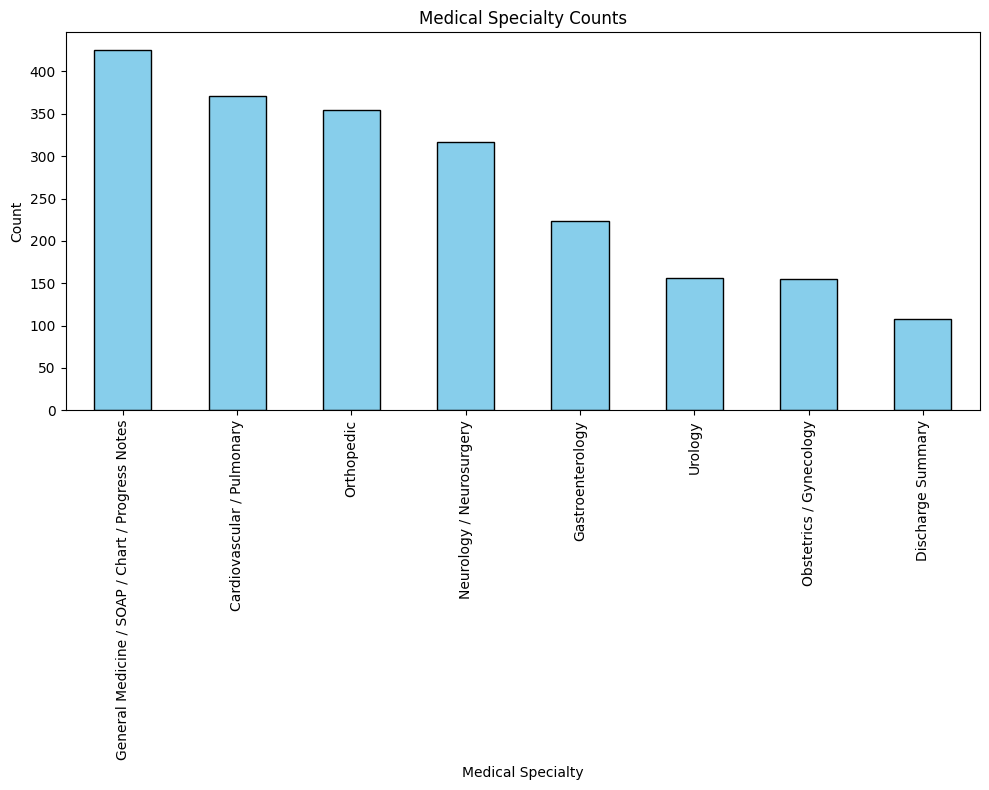

In [6]:
excluded_specialities = [
    'Surgery', 'Consult - History and Phy.',  'Radiology'
] 
df = df[~df['medical_specialty'].isin(excluded_specialities)]

df['medical_specialty'] = df['medical_specialty'].apply(
    lambda x: 'Neurology / Neurosurgery' if x in ['Neurology', 'Neurosurgery'] else x
)

df['medical_specialty'] = df['medical_specialty'].apply(
    lambda x: 'General Medicine / SOAP / Chart / Progress Notes' if x in ['General Medicine', 'SOAP / Chart / Progress Notes'] else x
)

speciality_count = utils.class_distribution(df.medical_specialty, verbose=False)
df = df[df.medical_specialty.isin(speciality_count[speciality_count >= MIN_SPECIALITY_THRESHOLD].index)]
_ = utils.class_distribution(df.medical_specialty, 'Medical Specialty', show_plot=True)

In [7]:
df['label'], uniques = pd.factorize(df.medical_specialty)
print("Unique medical specialties:")
for i, label in enumerate(uniques):
    print(f"{i}: {label}")

df.sample(5, random_state=42)

Unique medical specialties:
0: Cardiovascular / Pulmonary
1: Neurology / Neurosurgery
2: Urology
3: General Medicine / SOAP / Chart / Progress Notes
4: Orthopedic
5: Obstetrics / Gynecology
6: Gastroenterology
7: Discharge Summary


,medical_specialty,transcription,text,label
2226,Orthopedic,"PREOPERATIVE DIAGNOSES:,1. Cellulitis with as...",preoperative diagnoses . cellulitis with assoc...,4
4853,Cardiovascular / Pulmonary,"NAME OF PROCEDURE,1. Selective coronary angio...",name of procedure . selective coronary angiogr...,0
2102,Orthopedic,"XYZ, D.C.,60 Evergreen Place,Suite 902,East Or...",xyz d.c. evergreen place suite east orange nj re,4
2209,Orthopedic,"PREOPERATIVE DIAGNOSIS: , Painful ingrown toen...",preoperative diagnosis painful ingrown toenail...,4
1322,General Medicine / SOAP / Chart / Progress Notes,"PHYSICAL EXAMINATION:, Patient is a 46-year-o...",physical examination patient is a year old whi...,3


In [8]:
ros = RandomOverSampler(random_state=42)
df_resampled, y_resampled = ros.fit_resample(
    df[['text']],
    df['label']
)

df_resampled['label'] = y_resampled
print(f"Resampled Shape: {df_resampled.shape}")

Resampled Shape: (3400, 2)


In [9]:
train_df, test_df = train_test_split(df_resampled, test_size=DS_SPLIT, stratify=df_resampled['label'], random_state=42)
print(f"Train Shape: {train_df.shape}, Test Shape: {test_df.shape}")

Train Shape: (2720, 2), Test Shape: (680, 2)


In [10]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding=True, max_length=MAX_SEQ_LEN)

train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/2720 [00:00<?, ? examples/s]

Map:   0%|          | 0/680 [00:00<?, ? examples/s]

In [11]:
label2id = {label: idx for idx, label in enumerate(uniques)}
id2label = {idx: label for idx, label in enumerate(uniques)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(uniques),
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpie/distil-biobert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }

In [13]:
training_args = TrainingArguments(
    output_dir="./results",         
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
    greater_is_better=True,
    learning_rate=2e-5,             
    per_device_train_batch_size=BATCH_SIZE, 
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=10,             
    weight_decay=0.01,
    report_to="none",
    logging_dir=None,           
    logging_steps=-1
)

trainer = Trainer(
    model=model,       
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

  0%|          | 0/1700 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

{'eval_loss': 0.7808055281639099, 'eval_accuracy': 0.7352941176470589, 'eval_f1_weighted': 0.7205677213482536, 'eval_runtime': 2.5969, 'eval_samples_per_second': 261.846, 'eval_steps_per_second': 16.558, 'epoch': 1.0}


  0%|          | 0/43 [00:00<?, ?it/s]

{'eval_loss': 0.5459153056144714, 'eval_accuracy': 0.7926470588235294, 'eval_f1_weighted': 0.7853214498443626, 'eval_runtime': 2.6087, 'eval_samples_per_second': 260.666, 'eval_steps_per_second': 16.483, 'epoch': 2.0}


  0%|          | 0/43 [00:00<?, ?it/s]

{'eval_loss': 0.4388497769832611, 'eval_accuracy': 0.8294117647058824, 'eval_f1_weighted': 0.8278969477505397, 'eval_runtime': 2.6185, 'eval_samples_per_second': 259.686, 'eval_steps_per_second': 16.421, 'epoch': 3.0}


  0%|          | 0/43 [00:00<?, ?it/s]

{'eval_loss': 0.40983492136001587, 'eval_accuracy': 0.8441176470588235, 'eval_f1_weighted': 0.8408004488867024, 'eval_runtime': 2.6102, 'eval_samples_per_second': 260.521, 'eval_steps_per_second': 16.474, 'epoch': 4.0}


  0%|          | 0/43 [00:00<?, ?it/s]

{'eval_loss': 0.42923322319984436, 'eval_accuracy': 0.8411764705882353, 'eval_f1_weighted': 0.8377299758794963, 'eval_runtime': 2.618, 'eval_samples_per_second': 259.745, 'eval_steps_per_second': 16.425, 'epoch': 5.0}


  0%|          | 0/43 [00:00<?, ?it/s]

{'eval_loss': 0.46339401602745056, 'eval_accuracy': 0.8352941176470589, 'eval_f1_weighted': 0.8296652995576498, 'eval_runtime': 2.6104, 'eval_samples_per_second': 260.501, 'eval_steps_per_second': 16.473, 'epoch': 6.0}
{'train_runtime': 215.8608, 'train_samples_per_second': 126.007, 'train_steps_per_second': 7.875, 'train_loss': 0.5892884497549019, 'epoch': 6.0}


TrainOutput(global_step=1020, training_loss=0.5892884497549019, metrics={'train_runtime': 215.8608, 'train_samples_per_second': 126.007, 'train_steps_per_second': 7.875, 'total_flos': 1081049634570240.0, 'train_loss': 0.5892884497549019, 'epoch': 6.0})

In [14]:
eval_results = trainer.evaluate()
print(f"Evaluation results:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

  0%|          | 0/43 [00:00<?, ?it/s]

Evaluation results:
eval_loss: 0.4098
eval_accuracy: 0.8441
eval_f1_weighted: 0.8408
eval_runtime: 2.6983
eval_samples_per_second: 252.0150
eval_steps_per_second: 15.9360
epoch: 6.0000


  0%|          | 0/43 [00:00<?, ?it/s]

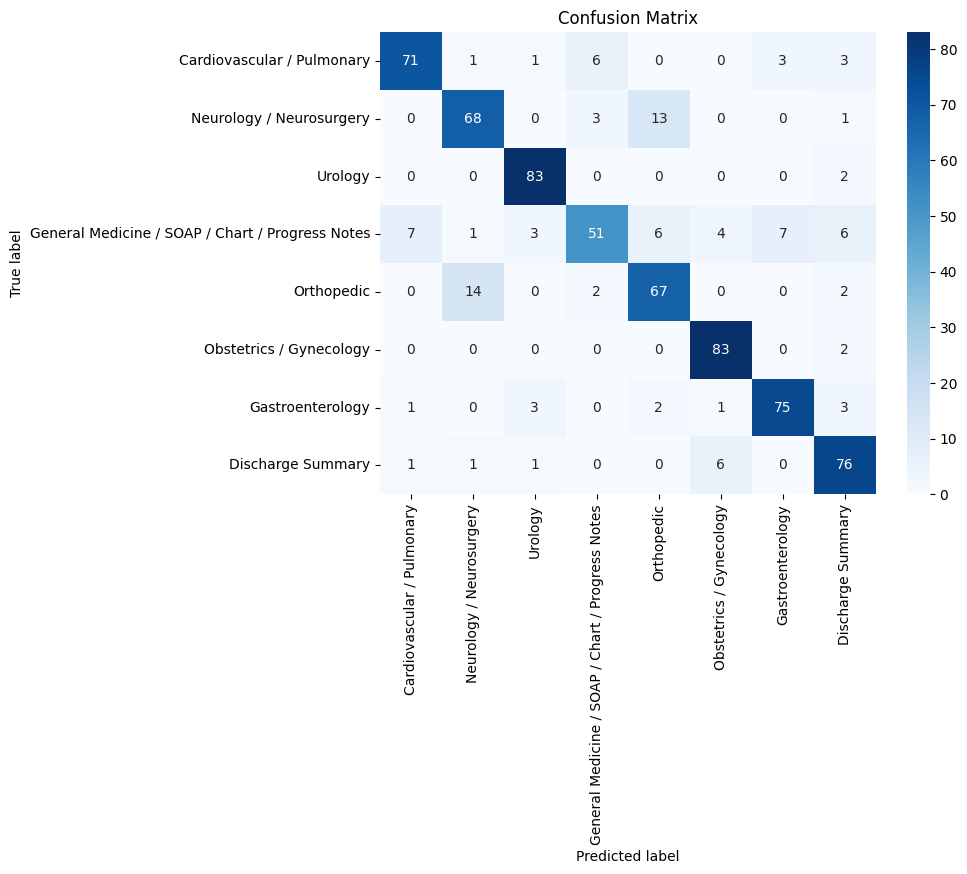

In [15]:
predictions = trainer.predict(test_ds)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

classes = list(id2label.values())
cm = confusion_matrix(y_true, y_pred)
utils.plot_confusion_matrix(cm, classes)

In [16]:
def classify(text):
    tokens = tokenizer.encode(text, return_tensors='pt', truncation=True, padding=True, max_length=MAX_SEQ_LEN)
    tokens = tokens.to(model.device)
    result = model(tokens)
    return int(torch.argmax(result.logits))

samples = pd.DataFrame()
for i in range(len(uniques)):
    sample = test_df[test_df.label == i].sample(1, random_state=21)
    samples = pd.concat([samples, sample])

samples = samples.reset_index(drop=True)
samples = samples.rename(columns={'label': 'true_label'})
samples['predicted_label'] = samples['text'].apply(classify)
samples

,text,true_label,predicted_label
0,comparison none. medications lopressor mg iv a...,0,0
1,chief complaint status epilepticus. history of...,1,1
2,preoperative diagnosis prostate cancer. postop...,2,2
3,history of present illness this is a year old ...,3,2
4,preoperative diagnosis volar laceration to rig...,4,4
5,preoperative diagnosis desires permanent steri...,5,5
6,chief complaint dysphagia and hematemesis whil...,6,6
7,admitting diagnoses . bradycardia. . dizziness...,7,7
